Consider linear problem

$$ y = G \theta + \eta $$

In [1]:
using LinearAlgebra
using PyPlot
include("../Inversion/IPS.jl")
include("../Inversion/Plot.jl")
include("../Inversion/Utility.jl")
function residual(method_type::String, m_oo, C_oo, m, C)
    if method_type == "gradient_descent"
        # under-determined case
        return -C_oo\(m - m_oo), 1/2.0*(inv(C) - inv(C_oo))
        
    elseif method_type == "natural_gradient_descent"
        # over-determined case
        return -(m - m_oo), C - C*(C_oo\C) 
        
    elseif method_type == "wasserstein_gradient_descent"
        # over-determined case
        return -C_oo\(m - m_oo), 2I - C_oo\C - C/C_oo 

    else
        error("Problem type : ", problem_type, " has not implemented!")
    end
end

function Continuous_Dynamics(method_type::String, m_oo, C_oo, m_0, C_0, Δt, N_t)

    N_θ = length(m_0)
    m = zeros(N_t+1, N_θ)
    C = zeros(N_t+1, N_θ, N_θ)
    
    m[1, :] = m_0
    C[1, :, :] = C_0

    for i = 1:N_t
        dm, dC = residual(method_type, m_oo, C_oo, m[i, :], C[i, :, :])
        m[i+1, :]    = m[i, :] + dm * Δt
        C[i+1, :, :] = C[i, :, :] + dC * Δt
    end

    return m, C
end

function KL_estimator(m_1,  C_1, m_2 , C_2)
    d = length(m_1)
    temp = C_2\C_1
    return 1/2*(  -log(det(temp)) - d + tr(temp) + (m_2 - m_1)'*(C_2\(m_2 - m_1)) )
end

KL_estimator (generic function with 1 method)

┌ Info: [1.0 0.0; 0.0 100.0]
└ @ Main In[2]:16
┌ Info: [1.0 0.0; 0.0 10.0]
└ @ Main In[2]:16
┌ Info: [1.0 0.0; 0.0 1.0]
└ @ Main In[2]:16


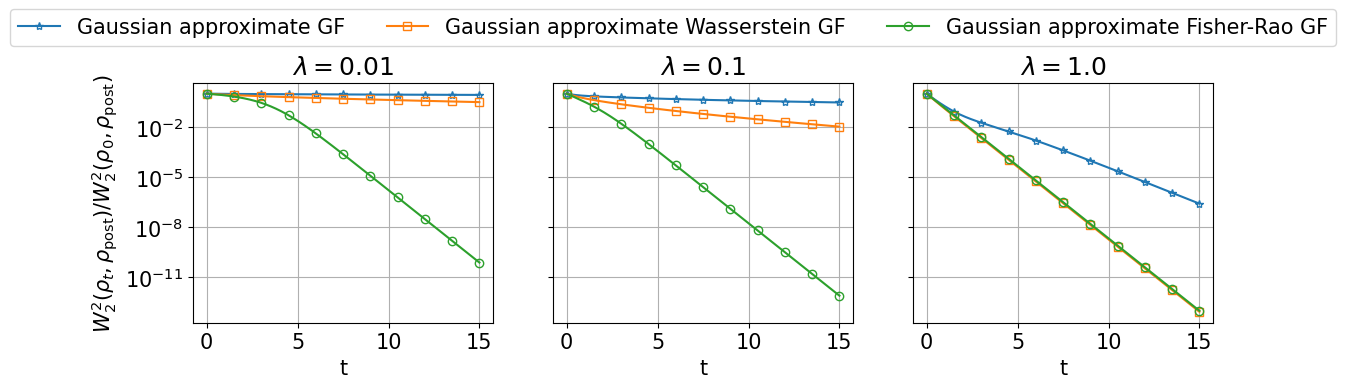

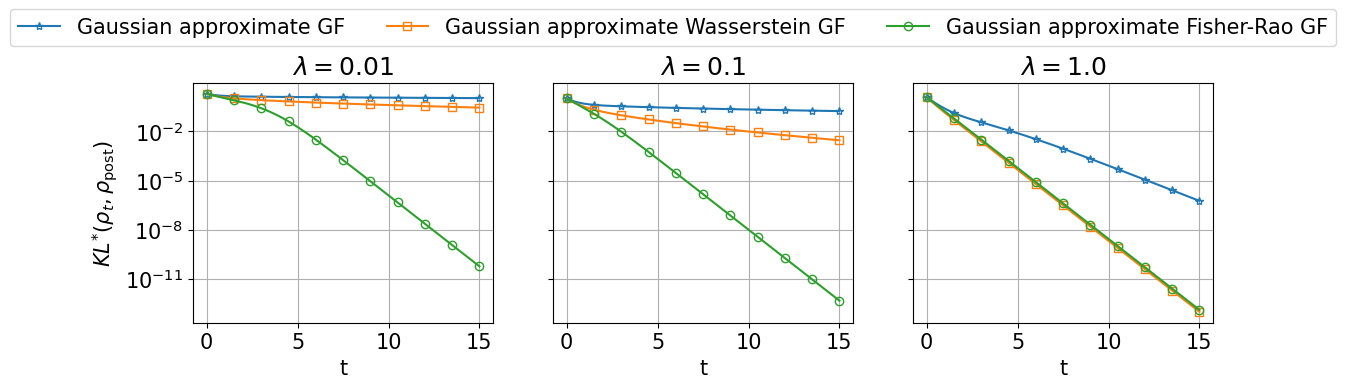

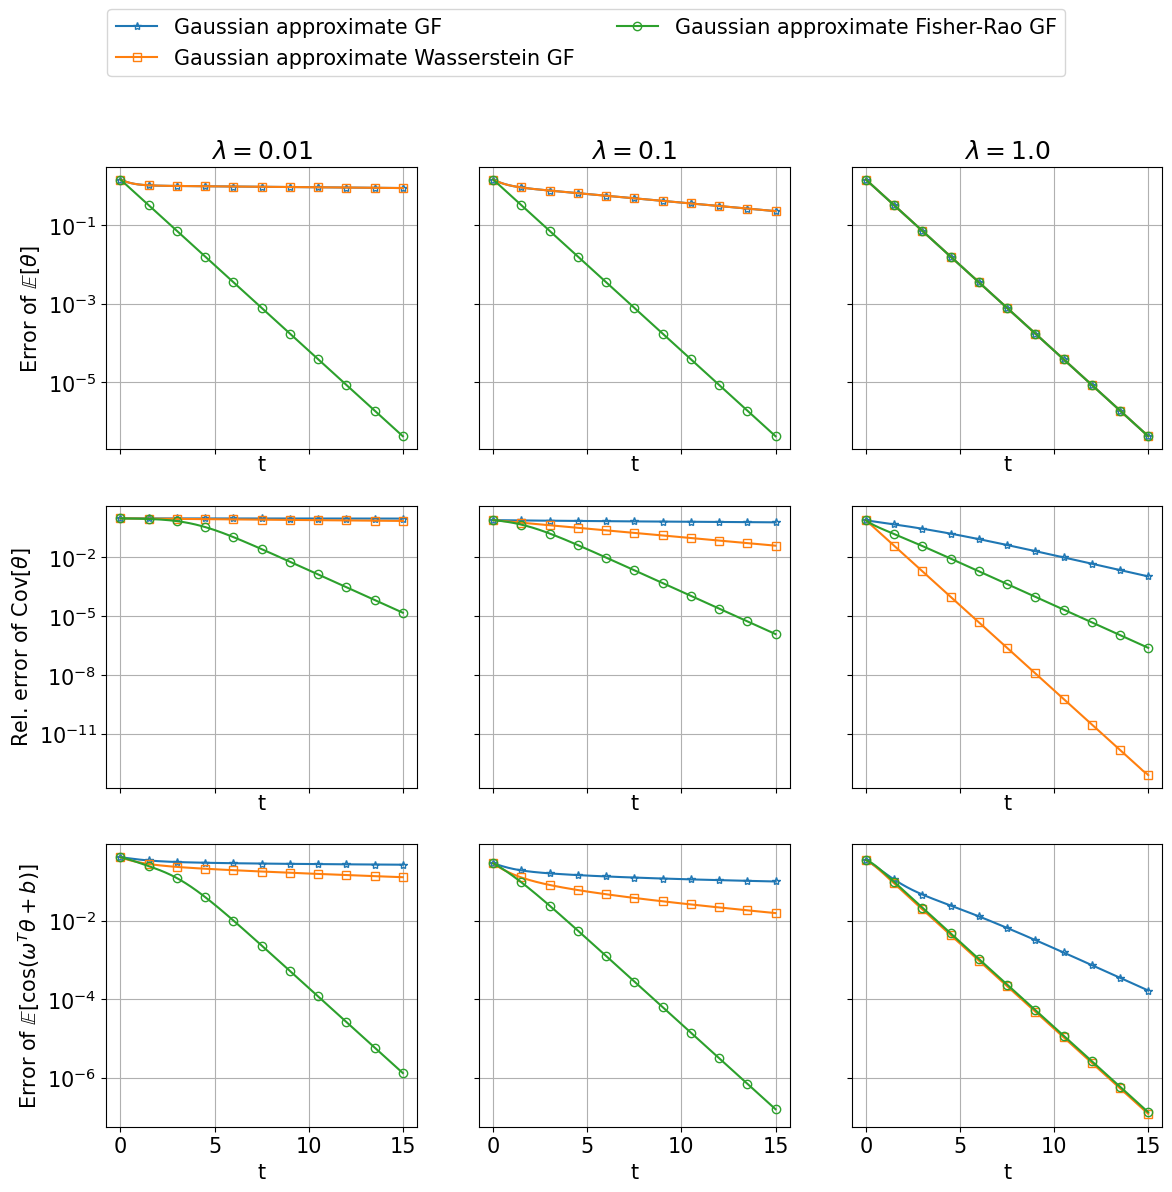

In [2]:
Random.seed!(42)
Δt, N_t = 1e-3, 15000
ϵs = [0.01, 0.1, 1]
# ϵs = [10, 100, 1000]
fig, ax = PyPlot.subplots(ncols=3, sharex=true, sharey=true, figsize=(12,4))
fig_err, ax_err = PyPlot.subplots(ncols=3, sharex=true, sharey=true, figsize=(12,4))
fig_conv, ax_conv = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))

ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)
for test_id = 1:length(ϵs)
    ϵ = ϵs[test_id]
    m_oo = [0; 0]
    C_oo = [1 0; 0 1/ϵ]
#     C_oo = 10*[1/ϵ 0.5/sqrt(ϵ); 0.5/sqrt(ϵ) 1]
    @info C_oo
    m_0 = [1; 1]
    C_0 = [1/2 0; 0 2.0]

    m_gd, C_gd   = Continuous_Dynamics("gradient_descent", m_oo, C_oo, m_0, C_0, Δt, N_t)
    m_ngd, C_ngd = Continuous_Dynamics("natural_gradient_descent", m_oo, C_oo, m_0, C_0, Δt, N_t)
    m_wgd, C_wgd = Continuous_Dynamics("wasserstein_gradient_descent", m_oo, C_oo, m_0, C_0, Δt, N_t)


    e_gd, e_ngd, e_wgd = zeros(N_t+1),  zeros(N_t+1),  zeros(N_t+1)

    U,S,V = svd(C_oo)
    C_oo_sqrt = U*Diagonal(sqrt.(S))*V'

    for i = 1:N_t+1

        U,S,V = svd(C_oo_sqrt * C_gd[i,:,:] * C_oo_sqrt)
        e_gd[i]  = ( norm(m_gd[i,:] - m_oo)^2 + tr(C_gd[i,:,:] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )

        U,S,V = svd(C_oo_sqrt * C_ngd[i,:,:] * C_oo_sqrt)
        e_ngd[i] = ( norm(m_ngd[i,:] - m_oo)^2 + tr(C_ngd[i,:,:] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )

        U,S,V = svd(C_oo_sqrt * C_wgd[i,:,:] * C_oo_sqrt)
        e_wgd[i] = ( norm(m_wgd[i,:] - m_oo)^2 + tr(C_wgd[i,:,:] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
    end
    
    e_gd  /= e_gd[1]
    e_ngd /= e_ngd[1]
    e_wgd /= e_wgd[1]
    
    ts = LinRange(0, Δt*N_t, N_t+1)
    
    ax[test_id].semilogy(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate GF")
    ax[test_id].semilogy(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate Wasserstein GF")
    ax[test_id].semilogy(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate Fisher-Rao GF")
    
    if test_id == 1  
        ax[test_id].set_ylabel(L" W^2_2(ρ_t , ρ_{\rm post}) / W^2_2(ρ_0 , ρ_{\rm post})")
    end
    
#     if test_id == length(ϵs)
#         legend()
#     end
        
    ax[test_id].set_xlabel("t")
    ax[test_id].grid("on")
    ax[test_id].set_title(L"\lambda = " * string(ϵ))
    
    
    
    e_gd = zeros(N_t+1)
    e_wgd = zeros(N_t+1)
    e_ngd = zeros(N_t+1)
    for i = 1:N_t+1
        e_gd[i]  = KL_estimator(m_gd[i,:],  C_gd[i,:,:], m_oo, C_oo)  
        e_wgd[i] = KL_estimator(m_wgd[i,:], C_wgd[i,:,:], m_oo, C_oo)  
        e_ngd[i] = KL_estimator(m_ngd[i,:], C_ngd[i,:,:], m_oo, C_oo)  
    end
    ax_err[test_id].semilogy(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate GF")
    ax_err[test_id].semilogy(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate Wasserstein GF")
    ax_err[test_id].semilogy(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_t, 10), label="Gaussian approximate Fisher-Rao GF")
    ax_err[test_id].set_title(L"\lambda = " * string(ϵs[test_id]))
    ax_err[test_id].set_xlabel("t")
    ax_err[test_id].grid("on")
    if test_id ==1
        ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    
    cos_ref = cos_error_estimation_particle(m_oo, C_oo, ω, b ) 
    gd_errors    = zeros(N_t+1, 3)
    ngd_errors    = zeros(N_t+1, 3)
    wgd_errors    = zeros(N_t+1, 3)
    
    for i = 1:N_t+1
        m_i, C_i = m_gd[i,:], C_gd[i,:,:]
        gd_errors[i, 1]  = norm(m_i .- m_oo)
        gd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        gd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        m_i, C_i = m_ngd[i,:], C_ngd[i,:,:]
        ngd_errors[i, 1]  = norm(m_i .- m_oo)
        ngd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        ngd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        m_i, C_i = m_wgd[i,:], C_wgd[i,:,:]
        wgd_errors[i, 1]  = norm(m_i .- m_oo)
        wgd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        wgd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
    end
    markevery=div(N_t, 10)
    ax_conv[1, test_id].semilogy(ts, gd_errors[:, 1],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax_conv[1, test_id].semilogy(ts, wgd_errors[:, 1], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax_conv[1, test_id].semilogy(ts, ngd_errors[:, 1], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
            
    ax_conv[2, test_id].semilogy(ts, gd_errors[:, 2],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax_conv[2, test_id].semilogy(ts, wgd_errors[:, 2], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax_conv[2, test_id].semilogy(ts, ngd_errors[:, 2], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
    
    ax_conv[3, test_id].semilogy(ts, gd_errors[:, 3],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax_conv[3, test_id].semilogy(ts, wgd_errors[:, 3], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax_conv[3, test_id].semilogy(ts, ngd_errors[:, 3], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
    
    ax_conv[1, test_id].set_title(L"\lambda = " * string(ϵ))
    ax_conv[1, test_id].set_xlabel("t")
    ax_conv[2, test_id].set_xlabel("t")
    ax_conv[3, test_id].set_xlabel("t")
    
    ax_conv[1, test_id].grid("on")
    ax_conv[2, test_id].grid("on")
    ax_conv[3, test_id].grid("on")
end

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig.subplots_adjust(bottom=0.15,top=0.75,left=0.1,right=0.95,hspace=0.2)
fig.savefig("Linear_gd_comp.pdf")


handles, labels = ax_err[1].get_legend_handles_labels()
fig_err.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_err.subplots_adjust(bottom=0.15,top=0.75,left=0.1,right=0.95,hspace=0.2)
fig_err.savefig("Linear_gd_converge.pdf")




handles, labels = ax_conv[1,1].get_legend_handles_labels()
fig_conv.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=2)
ax_conv[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax_conv[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax_conv[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")
fig_conv.subplots_adjust(bottom=0.05,top=0.85,left=0.1,right=0.98,hspace=0.2)
fig_conv.savefig("Gaussian_gd_converge.pdf")



In [3]:
handles, labels = ax_conv[1,1].get_legend_handles_labels()
fig_conv.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=2)
ax_conv[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax_conv[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax_conv[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")
fig_conv.subplots_adjust(bottom=0.05,top=0.89,left=0.1,right=0.98,hspace=0.2)
fig_conv.savefig("Gaussian_gd_converge.pdf")



┌ Info: ("Wasserstein", " preconditioner ", false)
└ @ Main In[4]:75
┌ Info: (L"$\lambdaean = $", [-0.10934416425146999, 1.0119513351582874], " ", [0.0, 0.0])
└ @ Main In[4]:76
┌ Info: ("cov = ", [0.8828158288019895 -0.42177651825633933; -0.42177651825633933 30.346626657589837], " ", [1.0 0.0; 0.0 100.0])
└ @ Main In[4]:77
┌ Info: ("Wasserstein", " preconditioner ", true)
└ @ Main In[4]:75
┌ Info: (L"$\lambdaean = $", [-0.19575312300451905, 0.3564822788820755], " ", [0.0, 0.0])
└ @ Main In[4]:76
┌ Info: ("cov = ", [0.8160745333604489 0.08041160436943776; 0.08041160436943776 81.83306533580654], " ", [1.0 0.0; 0.0 100.0])
└ @ Main In[4]:77
┌ Info: ("Stein", " preconditioner ", false)
└ @ Main In[4]:75
┌ Info: (L"$\lambdaean = $", [-0.0003854106014749403, 0.6411517966162167], " ", [0.0, 0.0])
└ @ Main In[4]:76
┌ Info: ("cov = ", [0.9258840511856115 0.003877206489987542; 0.003877206489987542 20.353736999469227], " ", [1.0 0.0; 0.0 100.0])
└ @ Main In[4]:77
┌ Info: ("Stein", " preconditione

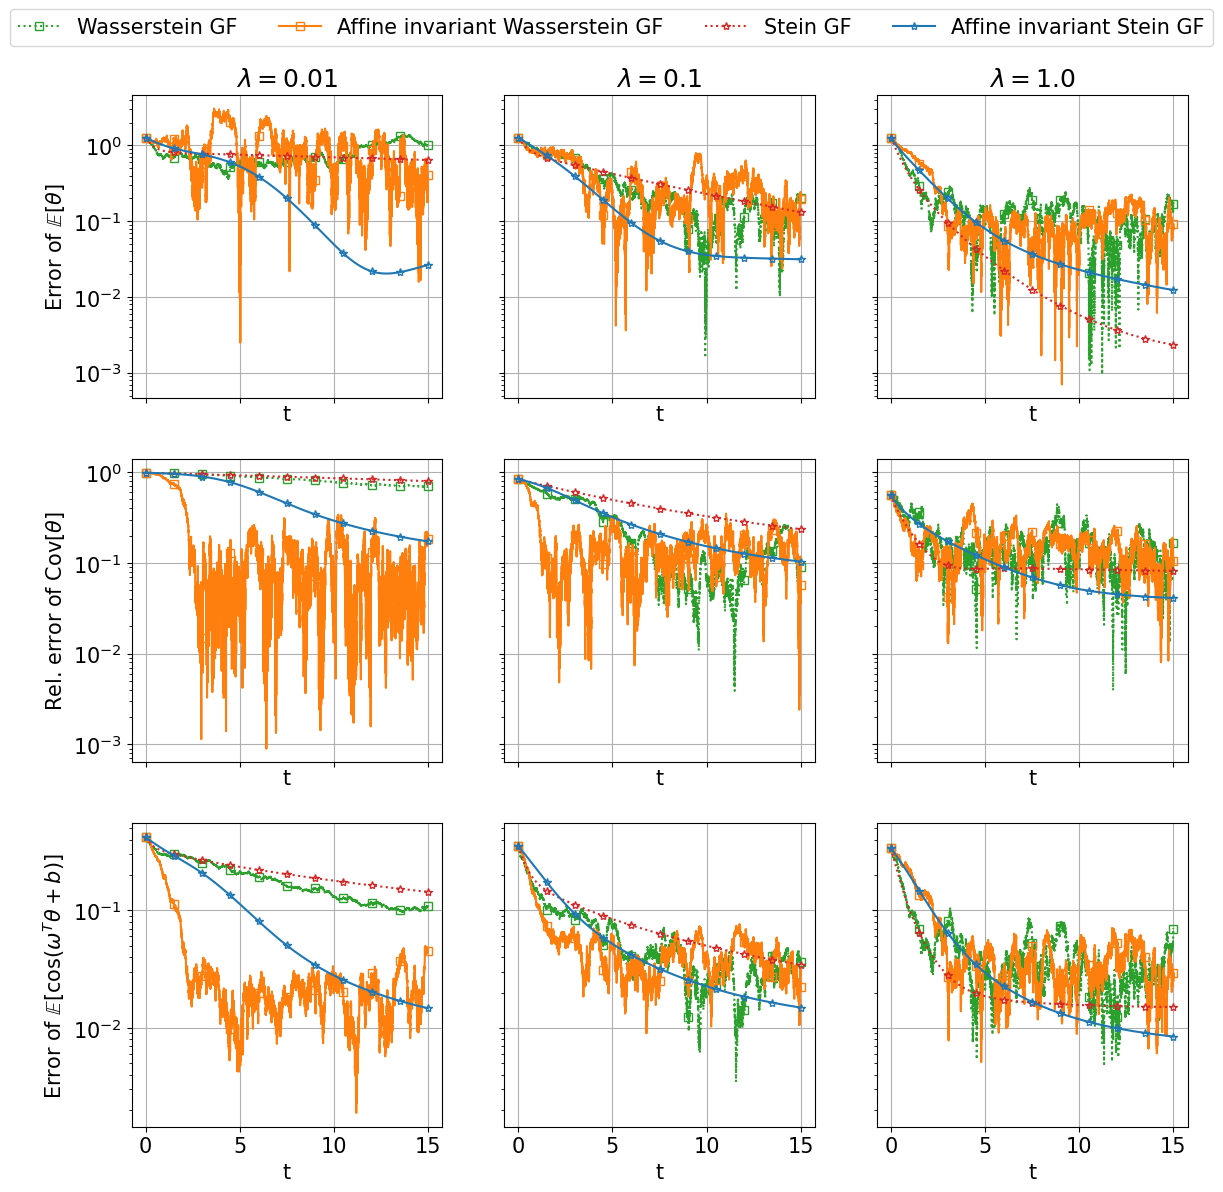

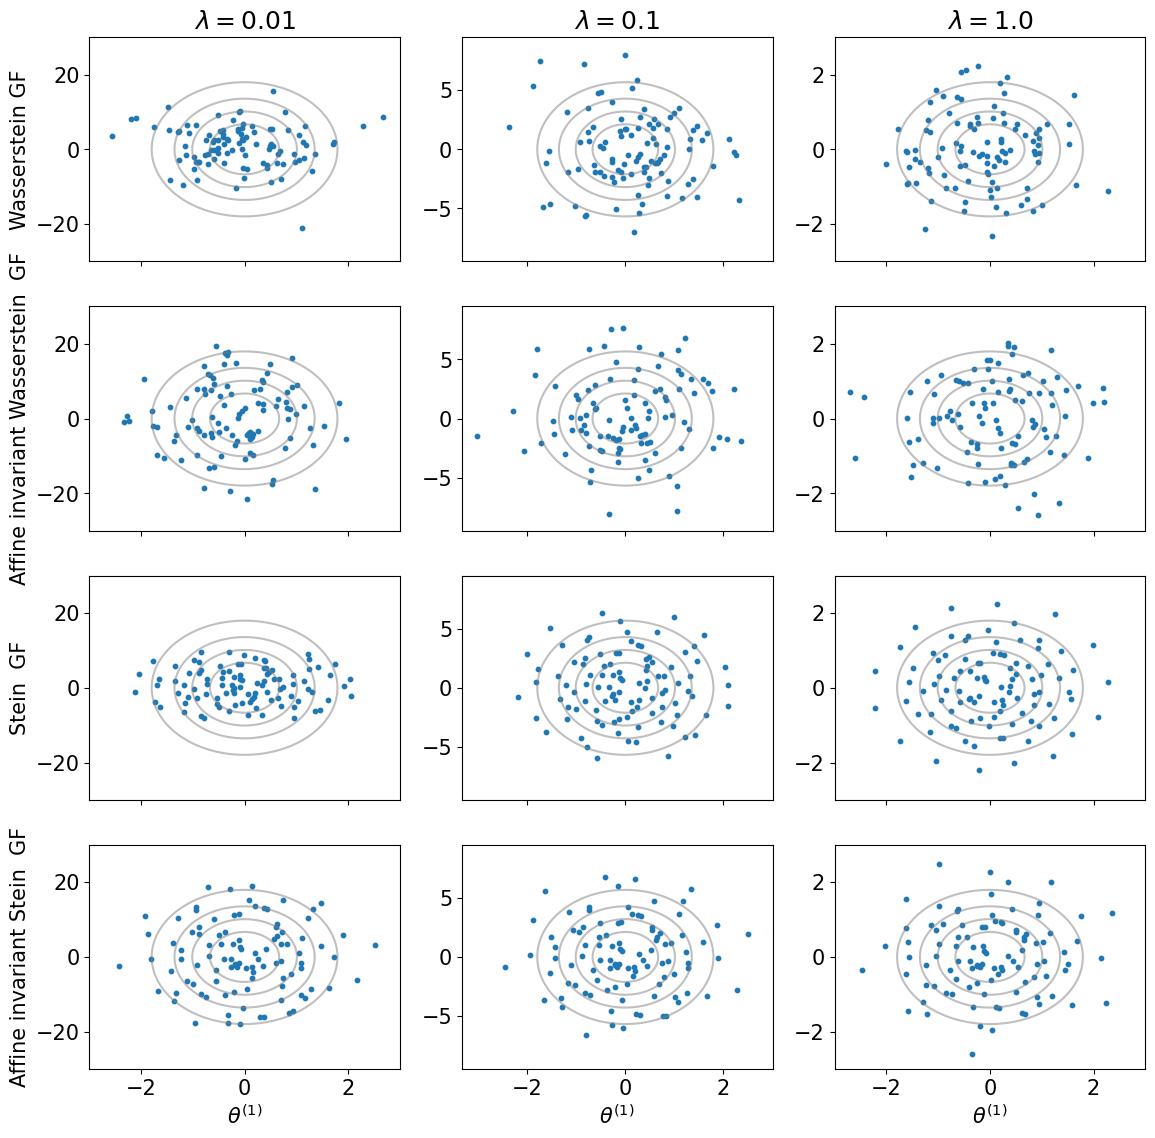

In [4]:
Random.seed!(42)
######################### TEST #######################################
mutable struct Setup_Param{IT<:Int, VEC, MAT}
    N_θ::IT
    m_oo::VEC
    C_oo::MAT
end

function compute_∇logρ(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    C_oo, m_oo = s_param.C_oo, s_param.m_oo
    # Φ   = 1/2*(θ - m_oo)'*(C_oo\(θ - m_oo))
    ∇logρ = -C_oo\(θ - m_oo)
    # ∇²Φ = C_oo
    return ∇logρ
end


N_θ = 2
m_0 = [1.0; 1.0]
C_0 = [1/2 0; 0 2.0]



ϵs = [0.01, 0.1, 1]
fig, ax = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))
fig_cont, ax_cont = PyPlot.subplots(ncols=3, nrows=4, sharex="col", sharey=false, figsize=(12,12))

N_ens = 100
Δt = 0.001
N_t = 15000
ts = LinRange(0, Δt*N_t, N_t+1)
θ0 = Array(rand(MvNormal(m_0, C_0), N_ens)')
ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)

for test_id = 1:length(ϵs)
    ϵ = ϵs[test_id]
    m_oo = [0.0; 0.0]
    C_oo = [1.0 0.0; 0.0 1/ϵ]

    s_param = Setup_Param(N_θ, m_oo, C_oo)
    
    cos_ref = cos_error_estimation_particle(m_oo, C_oo, ω, b ) 
    
    logρ(θ) = -0.5*θ'*(C_oo\θ)
    x_min, x_max = -3, 3
    y_min, y_max = -3/sqrt(ϵ), 3/sqrt(ϵ)
    N_x, N_y = 1000, 1000
    xx_cont = Array(LinRange(x_min, x_max, N_x))
    yy_cont = Array(LinRange(y_min, y_max, N_y))
    X_cont,Y_cont = repeat(xx_cont, 1, N_y), repeat(yy_cont, 1, N_x)'
    Z_cont = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z_cont[i, j] = logρ( [X_cont[i,j], Y_cont[i,j]] )
        end
    end
    Z_cont .= exp.(Z_cont)
    for i = 1:4
        ax_cont[i, test_id].contour(X_cont, Y_cont, Z_cont, 5, colors="grey", alpha=0.5)
    end

    for method in ["Wasserstein", "Stein"]
        for preconditioner in [false, true]
    
            ips_obj = IPS_Run(s_param, compute_∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner)

            ips_errors    = zeros(N_t+1, 3)
            for i = 1:N_t+1
                m_i, C_i = dropdims(mean(ips_obj.θ[i], dims=1), dims=1), construct_cov(ips_obj, ips_obj.θ[i])
                ips_errors[i, 1] = norm(m_i .- m_oo)
                ips_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
                ips_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
            end
            @info method, " preconditioner ", preconditioner
            @info L"\lambdaean = ", dropdims(mean(ips_obj.θ[end], dims=1), dims=1), " ", m_oo
            @info "cov = ", construct_cov(ips_obj, ips_obj.θ[end]), " ", C_oo
            
            

            ites = Array(0:N_t)
            markevery = div(N_t, 10)
            label, color, marker = "Fisher-Rao", "C2", "o"
            if (method  == "Wasserstein" || method  == "Stein")
                label = (preconditioner ? "Affine invariant "*method : method) * " GF"
                color = (method  == "Stein" ? "C0" : "C1")
                if method  ==  "Wasserstein" && ~preconditioner
                    color  = "C2"
                end
                if method  ==  "Stein" && ~preconditioner
                    color  = "C3"
                end
                
                marker = (method  == "Stein" ? "*" : "s")
            end
            linestyle = preconditioner ?  "solid" : "dotted"
            
            
            ax[1, test_id].semilogy(ts, ips_errors[:, 1], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            ax[2, test_id].semilogy(ts, ips_errors[:, 2], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            ax[3, test_id].semilogy(ts, ips_errors[:, 3], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            
            
            if (method == "Wasserstein" && ~preconditioner)
                ax_cont[1, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            elseif (method == "Wasserstein" && preconditioner)
                ax_cont[2, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            elseif (method == "Stein" && ~preconditioner)
                ax_cont[3, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            else 
                ax_cont[4, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            end

        end
    end

    ax_cont[1, test_id].set_title(L"\lambda = " * string(ϵ))            
    ax[1, test_id].set_title(L"\lambda = " * string(ϵ))
    ax[1, test_id].set_xlabel("t")
    ax[2, test_id].set_xlabel("t")
    ax[3, test_id].set_xlabel("t")
    
    ax[1, test_id].grid("on")
    ax[2, test_id].grid("on")
    ax[3, test_id].grid("on")
    
    
#     if test_id ==1
#         for i = 1:4
#             ax_cont[i,test_id].set_ylabel(L"\theta_{(2)}")
#         end
#     end
    ax_cont[4,test_id].set_xlabel(L"\theta^{(1)}")
    
end

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=4)
ax[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")

fig.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
fig.savefig("Gaussian_gd_particle_converge.pdf")


ax_cont[1, 1].set_ylabel("Wasserstein GF")
ax_cont[2, 1].set_ylabel("Affine invariant Wasserstein  GF")
ax_cont[3, 1].set_ylabel("Stein  GF")
ax_cont[4, 1].set_ylabel("Affine invariant Stein  GF")
fig_cont.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
fig_cont.savefig("Gaussian_gd_particle_contour.pdf")


In [5]:
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=4)
ax[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")

fig.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
fig.savefig("Gaussian_gd_particle_converge.pdf")


ax_cont[1, 1].set_ylabel("Wasserstein GF")
ax_cont[2, 1].set_ylabel("Affine invariant Wasserstein  GF")
ax_cont[3, 1].set_ylabel("Stein  GF")
ax_cont[4, 1].set_ylabel("Affine invariant Stein  GF")
fig_cont.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
fig_cont.savefig("Gaussian_gd_particle_contour.pdf")


┌ Info: [0.5747861653741749 0.030470838196369376; 0.030470838196369376 0.2580241840259119]
└ @ Main In[6]:12


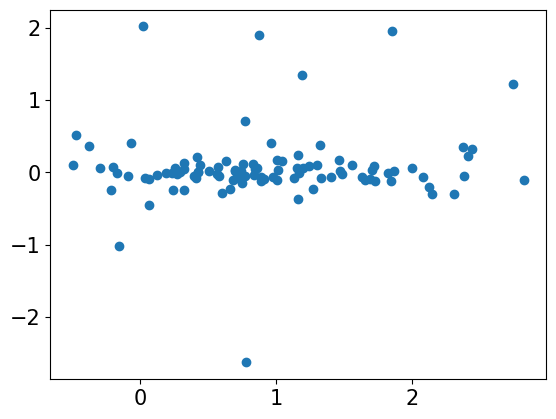

PyObject <matplotlib.collections.PathCollection object at 0x7f750931c990>

In [6]:
include("../Inversion/IPS.jl")
m_oo = [0.0; 0.0]
C_oo = [1.0 0.0; 0.0 1.0/100]

s_param = Setup_Param(N_θ, m_oo, C_oo)
N_ens = 100
θ0 = Array(rand(MvNormal(m_0, C_0), N_ens)')
Δt = 0.0002
N_t = 1000
ips_obj = IPS_Run(s_param, compute_∇logρ, θ0, N_ens, Δt, N_t, "Stein", true)

@info construct_cov(ips_obj, ips_obj.θ[end])
scatter(ips_obj.θ[end][:,1],ips_obj.θ[end][:,2])

In [ ]:
θ₁ θ₂